# CoverType EDA

In [34]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
from sklearn.preprocessing import LabelEncoder

%load_ext nb_black
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

## Load Data

In [2]:
# specify columns to keep and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
soil_type_cols = [(f"soil_type_{i+1}", True) for i in range(40)]

col_names = col_names + wilderness_area_cols + soil_type_cols + [("cover_type", True)]

In [3]:
df = pd.read_csv(
    "../data/covtype.data", header=None, names=[col_name[0] for col_name in col_names]
)

In [4]:
df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


## Preprocessing

By default this dataset poses a multiclass classification problem because the target variable `cover_type` takes on 7 different options. To simplify the problem here, we will only consider the two most populous classes and drop the rest of the data from consideration.


In [5]:
df.cover_type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: cover_type, dtype: int64

In [6]:
# drop records where cover_type isn't 1 or 2
df = df[df.cover_type.isin([1, 2])].reset_index(drop=True)

# label encode categorical columns (this will only change the cover_type column)
catcols = (col for col, iscat in col_names if iscat)

for col in catcols:
    df[col] = LabelEncoder().fit_transform(df[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


df = categorize(df, col_names)

In [7]:
df.dtypes

elevation                            int64
aspect                               int64
slope                                int64
horizontal_dist_to_hydrology         int64
vertical_dist_to_hydrology           int64
horizontal_dist_to_roadways          int64
hillshade_9am                        int64
hillshade_noon                       int64
hillshade_3pm                        int64
horizontal_dist_to_fire_points       int64
wilderness_area_1                 category
wilderness_area_2                 category
wilderness_area_3                 category
wilderness_area_4                 category
soil_type_1                       category
soil_type_2                       category
soil_type_3                       category
soil_type_4                       category
soil_type_5                       category
soil_type_6                       category
soil_type_7                       category
soil_type_8                       category
soil_type_9                       category
soil_type_1

In [8]:
df[[col for col, _ in wilderness_area_cols]].value_counts()

wilderness_area_1  wilderness_area_2  wilderness_area_3  wilderness_area_4
1                  0                  0                  0                    251914
0                  0                  1                  0                    212621
                   1                  0                  0                     27580
                   0                  0                  1                      3026
dtype: int64

- Wilderness area's are overlapping (aka non sequential), we might need to bunch these as a way to impose "artifical data drift"
- Also, they are not equally distributed


Let's reorder all records by this area.

In [36]:
# order dataset by wilderness area
df = pd.concat(
    [df[df[f"wilderness_area_{i}"] == 1].reset_index(drop=True) for i in (1, 3, 2, 4)]
).reset_index(drop=True)


<IPython.core.display.Javascript object>

In [10]:
# df[df.wilderness_area_1==1]
# df[df.wilderness_area_3==1]
# df[df.wilderness_area_2==1]
# df[df.wilderness_area_4==1]

## Does this dataset have drift?

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from test_harness.utils.utils import plot_experiment_error, plot_multiple_experiments

from test_harness.datasets.dataset import Dataset
from test_harness.experiments.experiment import Experiment
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.sqsi_experiment import SQSI_MRExperiment

In [27]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

ED_dataset = Dataset(full_df=df, column_mapping=column_mapping, window_size=5000)

model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)

In [40]:
%%time

baseline = BaselineExperiment(model=model, dataset=ED_dataset)
topline = ToplineExperiment(model=model, dataset=ED_dataset)

baseline.run()
topline.run()

# sqsi_mr = SQSI_MRExperiment(model=model, dataset=ED_dataset, k=50, significance_thresh=0.001)
# sqsi_mr.run()

CPU times: user 33.7 s, sys: 434 ms, total: 34.1 s
Wall time: 34.1 s


<IPython.core.display.Javascript object>

In [ ]:
# @window_size=5000
exps = [baseline, topline]
plot_multiple_experiments(exps)

### Toggle Window Size

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

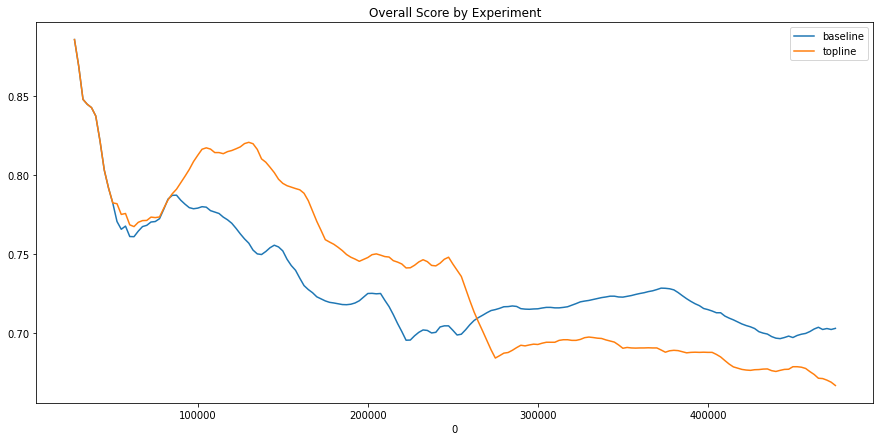

In [26]:
#25000
exps = [baseline, topline]
plot_multiple_experiments(exps)

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

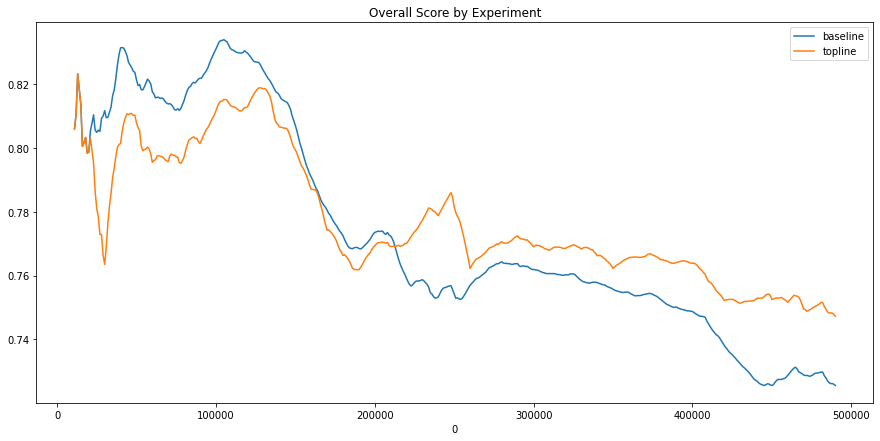

In [23]:
#10000
exps = [baseline, topline]
plot_multiple_experiments(exps)

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

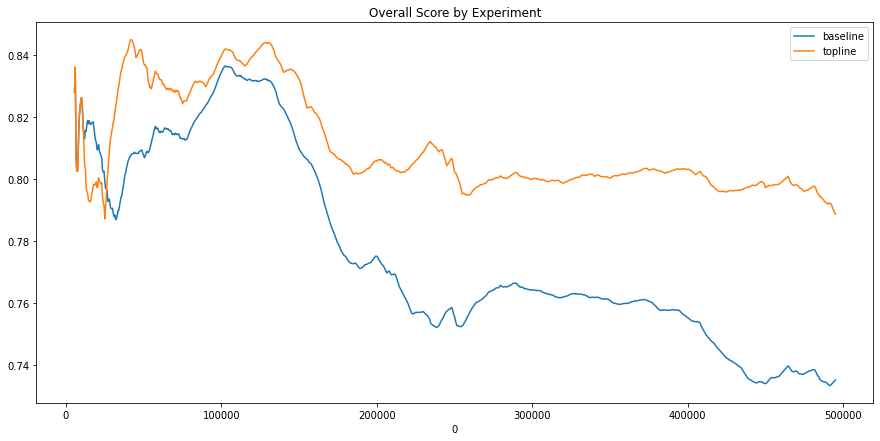

In [20]:
#5000
exps = [baseline, topline]
plot_multiple_experiments(exps)

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

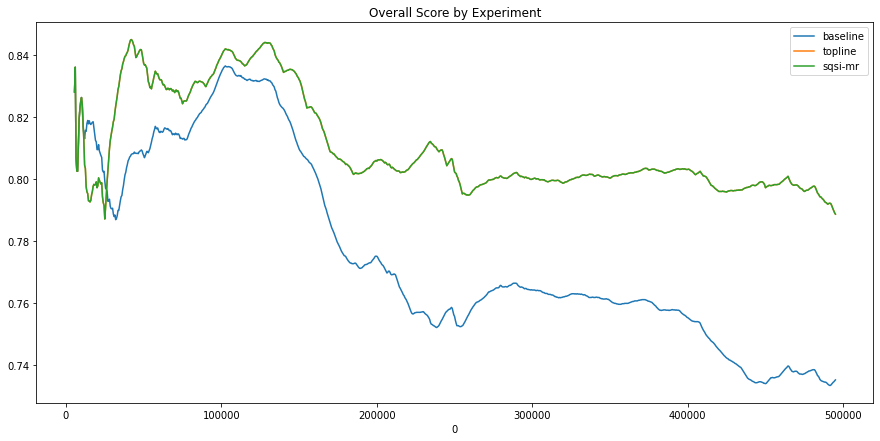

In [32]:
#5000 w/SQSI at k=50
exps = [baseline, topline, sqsi_mr]
plot_multiple_experiments(exps)

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

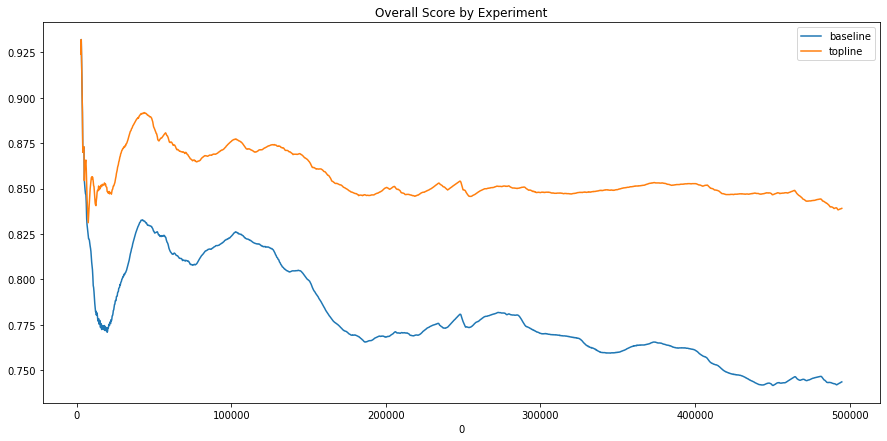

In [17]:
#2500
exps = [baseline, topline]
plot_multiple_experiments(exps)